In [1]:
%matplotlib inline
import Constants as C
from MakeModels import *
encoder = makeEncoder(C.batchSz)
decoder = makeDecoder()
autoencoder = makeAutoencoder(encoder,decoder)

autoencoder.load_weights('/home/ubuntu/SoftRobotRepresentation/ModelPrettyGoodBottleneck25.h5', by_name=True)

imageLSTM = makeImageLSTM(encoder)

Using TensorFlow backend.


(None, 25)
(1, None, 27)
(1, 64)
(1, 2)


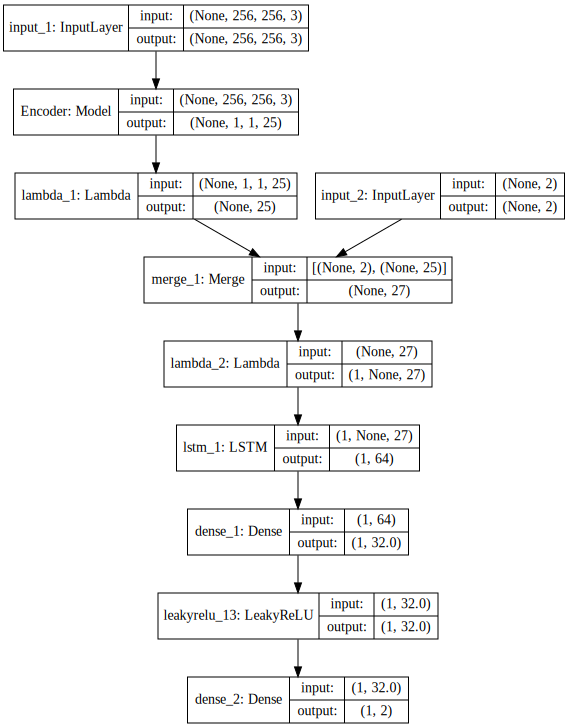

In [2]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(imageLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [ ]:
## Let's test some learning rates
import numpy as np
from numpy import random
import tqdm
from IPython.core.debugger import Pdb
from matplotlib import pyplot as plt

import pandas as pd


numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 100

trainPath = "/home/ubuntu/SoftRobotRepresentation/Data/Training/0/"
valPath = "/home/ubuntu/SoftRobotRepresentation/Data/Validation/0/"

positionFiles = ['/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv',
                 '/home/ubuntu/SoftRobotRepresentation/Data/recordingRight2.csv']

numFramesTrain = [21420,31430]
numFramesVal = [9180,13470]
numFrames = [e+f for e,f in zip(numFramesTrain,numFramesVal)]

posTables = [pd.read_csv(e) for e in positionFiles]

positionDataTrain = np.empty(shape=(0,2))
positionDataVal = np.empty(shape=(0,2))
for i in range(len(positionFiles)):
    positionData = posTables[i].as_matrix(columns=['x(m)','y(m)'])
    positionDataTrain = np.concatenate((positionDataTrain,positionData[:numFramesTrain[i],:]))
    positionDataVal = np.concatenate((positionDataVal,positionData[numFramesTrain[i]:numFrames[i],:]))
    
print str(positionDataTrain.shape) +" " + str(positionDataVal.shape)

def trainGenerator():
    files = os.listdir(trainPath)
    files = ['%s%06d.jpg'%(trainPath,i) for i in range(len(files))]
    res = np.zeros(shape=(C.timeSz,imDim,imDim,3))
    while True:
        for i in range(numBatchesPerEpoch):
            resPos = positionDataTrain[i*C.timeSz:(i+1)*(C.timeSz),:]
            for j in range(C.timeSz):
                index = i*C.timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataTrain[i*C.timeSz+C.predictAhead:(i+1)*C.timeSz+C.predictAhead,:]
            yield ([resPos,res],posRes)
        
def valGenerator():  
    files = os.listdir(valPath)
    files = ['%s%06d.jpg'%(valPath,i) for i in range(len(files))]
    res = np.zeros(shape=(C.timeSz,imDim,imDim,3))
    while True:
        for i in range(nValBatches):
            resPos = positionDataVal[i*C.timeSz:(i+1)*(C.timeSz),:]
            for j in range(C.timeSz):
                index = i*C.timeSz+j
                res[j,:] = plt.imread(files[index]).astype('float32')/255.0
                
            posRes = positionDataVal[i*C.timeSz+C.predictAhead:(i+1)*C.timeSz+C.predictAhead,:]
            yield ([resPos,res],posRes)
            
            

def trainGeneratorPlainPos():
    res = np.zeros(shape=(C.timeSz,2))
    while True:
        for i in range(numBatchesPerEpoch):
            res = positionDataTrain[i*C.timeSz:i*(C.timeSz+1),:]
            posRes = positionDataTrain[i*(C.timeSz+1)+C.predictAhead,:]
            yield (res,posRes)
        
def valGenerator():  
    res = np.zeros(shape=(C.timeSz,2))
    while True:
        for i in range(nValBatches):
            res = positionDataVal[i*C.timeSz:i*(C.timeSz+1),:]
            posRes = positionDataVal[i*(C.timeSz+1)+C.predictAhead,:]
            yield (res,posRes)

In [ ]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau


lr = 5e-2
print "Learning rate=" + str(lr)
print "Compiling model"
imageLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = imageLSTM.fit_generator(generator=trainGenerator(),
                                    samples_per_epoch=numBatchesPerEpoch*C.timeSz,
                                    nb_epoch=numEpochs,
                                    validation_data=valGenerator(),
                                    nb_val_samples=nValBatches*C.timeSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/0'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/LSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.2,patience=2)]
                                   )

In [41]:
import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 4

def generator(path,shuf=False):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,nFeatures))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            for j in range(C.batchSz):
                bi = baseIndices[j]
                X[j,:,:] = masterList[bi:bi+C.timeSz,:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]    
            yield (X,y)

In [ ]:
paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = generator(paths[0],shuf=True)
gengen.next()

In [42]:
from MakeModels import *

nFeatures = autoencoder.layers[-2].output_shape[-1]+2
featureLSTM = makeFeatureLSTM(nFeatures)

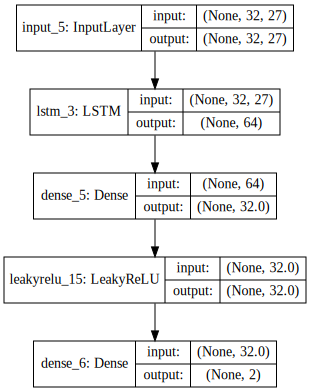

In [43]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(featureLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [48]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 200
numBatchesPerEpoch = 5000
nValBatches = 1000

featureLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/featureLSTMModel1.h5')


lr = 2e-1
print "Learning rate=" + str(lr)
print "Compiling model"
featureLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = featureLSTM.fit_generator(generator=generator(trainPath,shuf=True),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generator(valPath,shuf=True),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/featureLSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.5,patience=4)]
                                   )

Learning rate=0.5
Compiling model
Done compiling model
Epoch 1/200
17400/20000 [=========================>....] - ETA: 45s - loss: 4640.9310

KeyboardInterrupt: 

0.562571481961


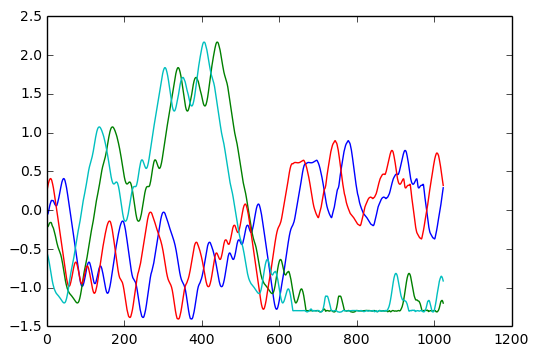

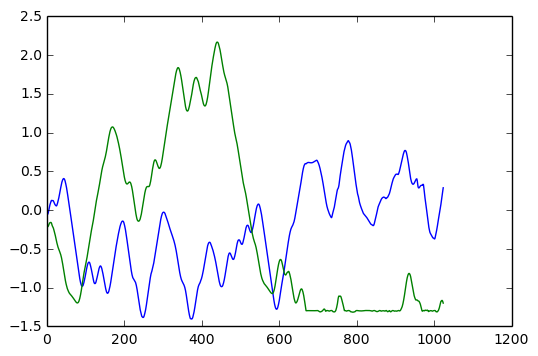

In [23]:
from matplotlib import pyplot as plt

import pandas as pd


paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = generator(paths[0],shuf=False)

nPoints = 1024
res = np.zeros((nPoints,2))
res3 = np.zeros((nPoints,2))

for i in range(nPoints/C.batchSz):
    bluff = gengen.next()
    stuff = bluff[0]
    cruff = bluff[1]
    
    res[i*C.batchSz:(i+1)*C.batchSz,:] = stuff[:,0,-2:]
    res3[i*C.batchSz:(i+1)*C.batchSz,:] = cruff
    
gengen = generator(paths[0],shuf=False)
res2 = np.zeros((nPoints,2))    
for i in range(nPoints/C.timeSz):
    stuff = gengen.next()
    stuff = stuff[0]
    
    res2[i*C.timeSz:(i+1)*C.timeSz,:] = stuff[0,:,-2:]
    
    for j in range(C.timeSz/C.batchSz - 1):
        gengen.next()
    

xvals = np.arange(res.shape[0])    
plt.figure(1)
plt.plot(xvals,res[:,-1],xvals,res[:,-2],xvals, res3[:,-1], xvals, res3[:,-2])

plt.figure(2)
plt.plot(xvals,res2[:,-1],xvals,res2[:,-2])


posTable = pd.read_csv('/home/ubuntu/SoftRobotRepresentation/Data/recordingRight.csv')
positionData = posTable.as_matrix(columns=['x(m)','y(m)'])

plt.figure(3)
# plt.plot(xvals,positionData[xvals,-1],xvals,positionData[xvals,-2])

In [4]:
positionLSTM = makePlainLSTM()

In [5]:
import math
import numpy as np
from IPython.core.debugger import Pdb

C.batchSz = 4

def generatorPos(path,shuf=False):
    masterList = np.load(path)
    nFeatures = masterList.shape[1]-2
        
    X = np.zeros((C.batchSz,C.timeSz,2))
    y = np.zeros((C.batchSz,2))
    while True:
        for i in range(int(masterList.shape[0]/C.batchSz)-1):
            baseIndices = np.arange(i*C.batchSz,(i+1)*C.batchSz)
            if(shuf):
                baseIndices = np.random.randint(0,masterList.shape[0]-C.timeSz,size=(C.batchSz,))
            for j in range(C.batchSz):
                bi = baseIndices[j]
                X[j,:,:] = masterList[bi:bi+C.timeSz,-4:-2]
                y[j,:] = masterList[bi+C.timeSz-1,-2:]    
            yield (X,y)

In [7]:
## Let's test some learning rates
from keras.optimizers import Adam
import numpy as np
from numpy import random
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau

trainPath = '/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy'
valPath = '/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy'

numEpochs = 50
numBatchesPerEpoch = 1000
nValBatches = 200


lr = 1e-1
print "Learning rate=" + str(lr)
print "Compiling model"
positionLSTM.compile(optimizer=Adam(lr=lr),loss='mse')
print "Done compiling model"
history = positionLSTM.fit_generator(generator=generatorPos(trainPath,shuf=True),
                                    samples_per_epoch=numBatchesPerEpoch*C.batchSz,
                                    nb_epoch=numEpochs,
                                    validation_data=generatorPos(valPath,shuf=True),
                                    nb_val_samples=nValBatches*C.batchSz,
                                    callbacks=[TensorBoard(log_dir='/home/ubuntu/SoftRobotRepresentation/Data/Logs/1'),
                                               ModelCheckpoint('/home/ubuntu/SoftRobotRepresentation/positionLSTMModel.h5'),
                                               ReduceLROnPlateau(factor=0.2,patience=2)]
                                   )

Learning rate=0.1
Compiling model
Done compiling model
Epoch 1/50
4000/4000 [==============================] - 72s - loss: 0.7116 - val_loss: 0.2228
Epoch 2/50
4000/4000 [==============================] - 71s - loss: 0.5879 - val_loss: 1.2439
Epoch 3/50
4000/4000 [==============================] - 70s - loss: 0.4664 - val_loss: 2.4094
Epoch 4/50
4000/4000 [==============================] - 70s - loss: 0.3999 - val_loss: 0.5229
Epoch 5/50
4000/4000 [==============================] - 70s - loss: 0.2560 - val_loss: 0.2112
Epoch 6/50
4000/4000 [==============================] - 70s - loss: 0.2556 - val_loss: 0.3012
Epoch 7/50
4000/4000 [==============================] - 71s - loss: 0.2452 - val_loss: 0.2319
Epoch 8/50
4000/4000 [==============================] - 71s - loss: 0.2489 - val_loss: 0.2787
Epoch 9/50
4000/4000 [==============================] - 69s - loss: 0.2022 - val_loss: 0.2192
Epoch 10/50
4000/4000 [==============================] - 68s - loss: 0.1924 - val_loss: 0.1950
Epoc

KeyboardInterrupt: 

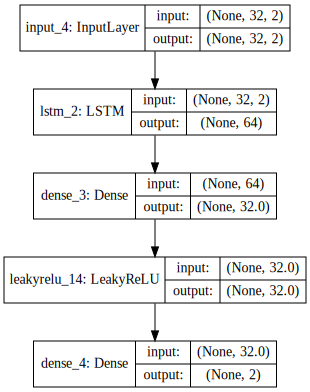

In [4]:
from IPython.display import SVG,display
from keras.utils.visualize_util import model_to_dot

display(SVG(model_to_dot(positionLSTM,show_shapes=True).create(prog='dot', format='svg')))

In [21]:
positionLSTM.load_weights('/home/ubuntu/SoftRobotRepresentation/positionLSTMModel.h5')

from matplotlib import pyplot as plt

import pandas as pd
from tqdm import tqdm


paths = ['/home/ubuntu/SoftRobotRepresentation/Data/trainFeats.npy','/home/ubuntu/SoftRobotRepresentation/Data/valFeats.npy']
gengen = generator(paths[0],shuf=False)

nPoints = 2048
X = np.zeros((nPoints,2))
y = np.zeros((nPoints,2))
ypred = np.zeros((nPoints,2))

for i in tqdm(range(nPoints/C.batchSz)):
    bluff = gengen.next()
    stuff = bluff[0]
    cruff = bluff[1]
    
    inp = stuff[:,:,-2:]
    oup = positionLSTM.predict_on_batch(inp)
    
    X[i*C.batchSz:(i+1)*C.batchSz,:] = stuff[:,0,-2:]
    y[i*C.batchSz:(i+1)*C.batchSz,:] = cruff
    ypred[i*C.batchSz:(i+1)*C.batchSz,:] = oup

100%|██████████| 512/512 [00:06<00:00, 76.59it/s]


(2048, 2)


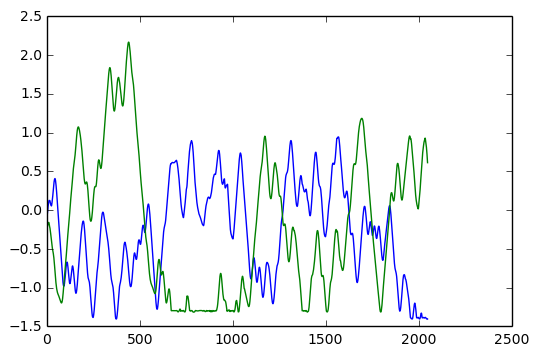

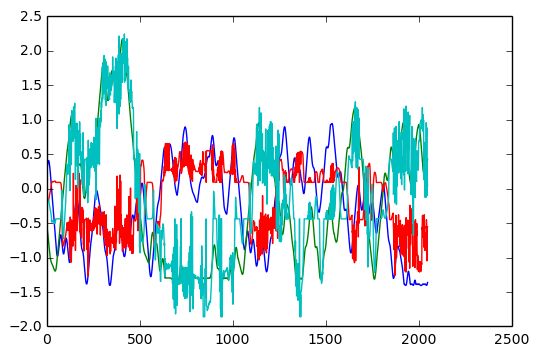

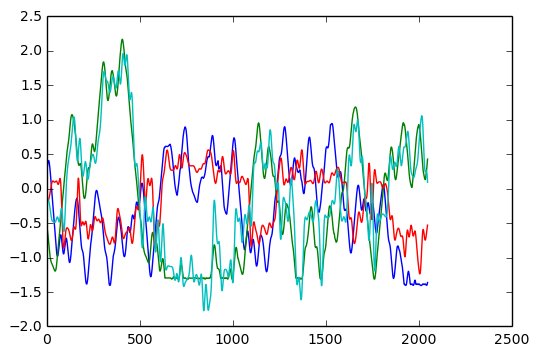

In [40]:
from scipy import signal 

print ypred.shape
[b,a] = signal.butter(10,0.1)
ypredlow = np.zeros_like(ypred)
ypredlow[:,-1] = signal.filtfilt(b,a,ypred[:,-1])
ypredlow[:,-2] = signal.filtfilt(b,a,ypred[:,-2])
xvals = np.arange(X.shape[0])    
plt.figure(1)
plt.plot(xvals,X[:,-1],xvals,X[:,-2])
plt.figure(2)
plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypred[:,-1],xvals,ypred[:,-2])
plt.figure(3)
plt.plot(xvals,y[:,-1], xvals, y[:,-2],xvals,ypredlow[:,-1],xvals,ypredlow[:,-2])